In [2]:
import pandas as pd
import numpy as np
from nsepy.derivatives import get_expiry_date
from nsepy import get_history
from datetime import date
import time
import mibian
import talib
from sklearn import tree
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

### Data

In [3]:
expiry = get_expiry_date(year=2022, month=9)
expiry

{datetime.date(2022, 9, 1),
 datetime.date(2022, 9, 6),
 datetime.date(2022, 9, 8),
 datetime.date(2022, 9, 13),
 datetime.date(2022, 9, 15),
 datetime.date(2022, 9, 20),
 datetime.date(2022, 9, 22),
 datetime.date(2022, 9, 27),
 datetime.date(2022, 9, 29)}

In [ ]:
master_df=pd.DataFrame()

years=[2017,2018,2019,2020,2021]
months=list(range(1,13))


#years=[2020]
#months=list(range(1,3))

for year in years:
    for month in months:
        try:
            print(year,month)
            time.sleep(10)

            expiry = max(get_expiry_date(year=year, month=month))
            start_date=date(year,month,1)
            end_date=expiry

            expiry_df=pd.DataFrame()

            cols=['Symbol', 'Expiry', 'Option Type', 'Strike Price', 'Open', 'High', 'Low', 'Close', 'Last']

            #cols=['Symbol', 'Expiry', 'Option Type', 'Strike Price', 'Close', 'Last']

            nifty_fut = get_history(symbol="NIFTY",
                                    start=start_date,
                                    end=end_date,
                                    index=True,
                                    futures=True,
                                    expiry_date=expiry)

            nifty_fut["Option Type"]="FUT"
            nifty_fut["Strike Price"]=np.nan
            nifty_fut=nifty_fut[cols]

            expiry_df=pd.concat([expiry_df,nifty_fut])
            
            master_df=pd.concat([master_df,nifty_fut])
            master_df.to_csv("data.csv")

            strike_multiplier=100
            perc_away=10
            low=nifty_fut["Low"].min()
            low=low-(low*perc_away/100.)
            low_strike=(int(low)//100)*100

            high=nifty_fut["High"].max()
            high=high+(high*perc_away/100.)
            high_strike=(int(high)//100)*100

            strike_list=(list(range(low_strike,high_strike+strike_multiplier,strike_multiplier)))

            print(low_strike,high_strike,strike_list)

            for strikePrice in strike_list:


                nifty_opt = get_history(symbol="NIFTY",
                                    start=start_date,
                                    end=end_date,
                                        index=True,
                                        option_type='CE',
                                        strike_price=strikePrice,
                                        expiry_date=expiry)
                expiry_df=pd.concat([expiry_df,nifty_opt[cols]])
                master_df=pd.concat([master_df,nifty_opt[cols]])
                master_df.to_csv("data.csv")

                nifty_opt = get_history(symbol="NIFTY",
                                    start=start_date,
                                    end=end_date,
                                        index=True,
                                        option_type='PE',
                                        strike_price=strikePrice,
                                        expiry_date=expiry)
                expiry_df=pd.concat([expiry_df,nifty_opt[cols]])
                master_df=pd.concat([master_df,nifty_opt[cols]])
                master_df.to_csv("data.csv")
                
            #master_df=pd.concat([master_df,expiry_df])
            #master_df.to_csv("data.csv")
        except Exception as e:
            print(e)





In [4]:
master_df=pd.read_csv("data.csv")
master_df["Date"]=pd.to_datetime(master_df["Date"])
master_df

,Date,Symbol,Expiry,Option Type,Strike Price,Open,High,Low,Close,Last
0,2017-01-02,NIFTY,2017-01-25,FUT,NaN,8215.05,8218.8,8151.00,8192.10,8191.10
1,2017-01-03,NIFTY,2017-01-25,FUT,NaN,8200.00,8228.0,8159.00,8196.50,8189.55
2,2017-01-04,NIFTY,2017-01-25,FUT,NaN,8202.25,8223.4,8187.30,8204.05,8207.90
3,2017-01-05,NIFTY,2017-01-25,FUT,NaN,8254.70,8298.7,8236.15,8288.20,8287.50
4,2017-01-06,NIFTY,2017-01-25,FUT,NaN,8305.55,8329.6,8256.50,8267.65,8268.10
...,...,...,...,...,...,...,...,...,...,...
67041,2021-12-24,NIFTY,2021-12-30,PE,19400.0,2406.25,2452.5,2406.25,2448.00,2448.00
67042,2021-12-27,NIFTY,2021-12-30,PE,19400.0,0.00,0.0,0.00,2448.00,2448.00
67043,2021-12-28,NIFTY,2021-12-30,PE,19400.0,0.00,0.0,0.00,2448.00,2448.00
67044,2021-12-29,NIFTY,2021-12-30,PE,19400.0,0.00,0.0,0.00,2448.00,2448.00


In [ ]:
# Creating Strangle Combinations

strangle_df=pd.DataFrame()

for expiry in master_df["Expiry"].unique():
    print(expiry)
    expiry_df=master_df[master_df["Expiry"]==expiry]
    expiry_df_fut=expiry_df[expiry_df["Option Type"]=="FUT"]
    expiry_df_opt=expiry_df[expiry_df["Option Type"]!="FUT"]

    expiry_df_fut.rename(columns={"Close":"Close_FUT"},inplace=True)
    expiry_df_opt=pd.merge(expiry_df_opt,expiry_df_fut[["Expiry","Date","Close_FUT"]],left_on=["Expiry","Date"],right_on=["Expiry","Date"])
    unique_strikes=list(expiry_df_opt["Strike Price"].unique())

    for strike1 in unique_strikes:
        for strike2 in unique_strikes:

            try:

                leg1=expiry_df_opt[(expiry_df_opt["Option Type"]=="CE")&(expiry_df_opt["Strike Price"]==strike1)]
                leg2=expiry_df_opt[(expiry_df_opt["Option Type"]=="PE")&(expiry_df_opt["Strike Price"]==strike2)]

                strangle=pd.merge(leg1,leg2,left_on=["Expiry","Date"],right_on=["Expiry","Date"],how="outer",suffixes=["leg1","leg2"])
                strangle_df=pd.concat([strangle_df,strangle])

            except Exception as e:
                 print(strike1,strike2,e)
                    
    strangle_df.to_csv("strangle_data.csv")
        

In [5]:
strangles=pd.read_csv("strangle_data.csv")
strangles.drop(columns=["Unnamed: 0"],inplace=True)
strangles

,Date,Symbolleg1,Expiry,Option Typeleg1,Strike Priceleg1,Openleg1,Highleg1,Lowleg1,Closeleg1,Lastleg1,Close_FUTleg1,Symbolleg2,Option Typeleg2,Strike Priceleg2,Openleg2,Highleg2,Lowleg2,Closeleg2,Lastleg2,Close_FUTleg2
0,2017-01-02,NIFTY,2017-01-25,CE,7300.0,889.15,901.95,860.7,901.95,901.95,8192.10,NIFTY,PE,7300.0,3.50,4.80,3.40,4.10,4.20,8192.10
1,2017-01-03,NIFTY,2017-01-25,CE,7300.0,886.60,919.00,858.0,887.70,884.50,8196.50,NIFTY,PE,7300.0,3.95,4.50,2.85,3.25,3.35,8196.50
2,2017-01-04,NIFTY,2017-01-25,CE,7300.0,895.55,919.80,889.0,895.95,896.00,8204.05,NIFTY,PE,7300.0,3.00,3.30,2.65,2.95,2.85,8204.05
3,2017-01-05,NIFTY,2017-01-25,CE,7300.0,915.90,990.25,915.7,976.45,974.95,8288.20,NIFTY,PE,7300.0,1.40,2.85,1.40,2.00,1.95,8288.20
4,2017-01-06,NIFTY,2017-01-25,CE,7300.0,1000.50,1020.00,953.0,960.30,958.20,8267.65,NIFTY,PE,7300.0,1.80,1.95,1.45,1.60,1.45,8267.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107292,2021-12-24,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,17003.80,NIFTY,PE,15300.0,3.10,3.10,1.75,1.95,1.90,17003.80
1107293,2021-12-27,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,17103.40,NIFTY,PE,15300.0,2.20,2.20,1.60,1.80,1.85,17103.40
1107294,2021-12-28,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,17246.75,NIFTY,PE,15300.0,1.35,1.65,1.05,1.25,1.25,17246.75
1107295,2021-12-29,NIFTY,2021-12-30,CE,15300.0,1945.50,1945.50,1945.5,1945.50,1945.50,17215.90,NIFTY,PE,15300.0,1.25,1.25,0.75,0.85,0.80,17215.90


In [6]:
strangles["Valid_Strangle"]="NO"
strangles["CE_ITMNESS"]=(strangles["Close_FUTleg1"]-strangles["Strike Priceleg1"])*100./strangles["Close_FUTleg1"]
strangles["PE_ITMNESS"]=-1*(strangles["Close_FUTleg1"]-strangles["Strike Priceleg2"])*100./strangles["Close_FUTleg1"]

threshold=-0.5 #Max ITM ness

strangles.loc[(strangles["CE_ITMNESS"]<threshold)&(strangles["PE_ITMNESS"]<threshold),"Valid_Strangle"]="YES"
strangles["Strangle_Price"]=strangles["Closeleg1"]+strangles["Closeleg2"]

strangles["Strangle_id"]=strangles["Expiry"]+"-"+strangles["Strike Priceleg1"].astype(str)+"-"+strangles["Strike Priceleg2"].astype(str)


#Margin Calculator:


strangles["Leg1_Val1"]=strangles["Closeleg1"]+(0.1*strangles["Close_FUTleg1"])-(strangles["Strike Priceleg1"]-strangles["Close_FUTleg1"])
strangles["Leg1_Val2"]=strangles["Closeleg1"]+(0.1*strangles["Strike Priceleg1"])
strangles["Margin_Leg1"]=(strangles[["Leg1_Val1", "Leg1_Val2"]].max(axis=1))

strangles["Leg2_Val1"]=strangles["Closeleg2"]+(0.1*strangles["Close_FUTleg2"])-(strangles["Close_FUTleg2"]-strangles["Strike Priceleg2"])
strangles["Leg2_Val2"]=strangles["Closeleg2"]+(0.1*strangles["Strike Priceleg2"])
strangles["Margin_Leg2"]=(strangles[["Leg2_Val1", "Leg2_Val2"]].max(axis=1))

strangles["Margin"]=strangles["Margin_Leg1"]+strangles["Margin_Leg2"]

strangles.drop(columns=["Leg1_Val1","Leg1_Val2","Leg2_Val1","Leg2_Val2","Margin_Leg1","Margin_Leg2"],inplace=True)

In [ ]:
strangles["Date"]=pd.to_datetime(strangles["Date"])
strangles["Expiry"]=pd.to_datetime(strangles["Expiry"])

strangles["Days_To_Expiry"]=(strangles["Expiry"]-strangles["Date"])
strangles["Days_To_Expiry"]=list(map(lambda x: 1+int(str(x).split(" ")[0]),strangles["Days_To_Expiry"]))



#Drop NA values

strangles=strangles[~strangles["Close_FUTleg1"].isnull()]
strangles=strangles[~strangles["Strike Priceleg1"].isnull()]
strangles=strangles[~strangles["Days_To_Expiry"].isnull()]
strangles=strangles[~strangles["Closeleg1"].isnull()]

strangles=strangles[~strangles["Close_FUTleg2"].isnull()]
strangles=strangles[~strangles["Strike Priceleg2"].isnull()]
strangles=strangles[~strangles["Closeleg2"].isnull()]


strangles["CallIV"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","CallIV"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],callPrice=w).impliedVolatility,strangles.loc[strangles["Valid_Strangle"]=="YES","Closeleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))


strangles["CallDelta"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","CallDelta"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).callDelta,strangles.loc[strangles["Valid_Strangle"]=="YES","CallIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))

strangles["CallVega"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","CallVega"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).vega,strangles.loc[strangles["Valid_Strangle"]=="YES","CallIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))

strangles["CallTheta"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","CallTheta"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).callTheta,strangles.loc[strangles["Valid_Strangle"]=="YES","CallIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))

strangles["CallGamma"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","CallGamma"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).gamma,strangles.loc[strangles["Valid_Strangle"]=="YES","CallIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))


strangles["PutIV"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","PutIV"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],putPrice=w).impliedVolatility,strangles.loc[strangles["Valid_Strangle"]=="YES","Closeleg2"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg2"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))


strangles["PutDelta"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","PutDelta"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).putDelta,strangles.loc[strangles["Valid_Strangle"]=="YES","PutIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg2"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))

strangles["PutVega"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","PutVega"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).vega,strangles.loc[strangles["Valid_Strangle"]=="YES","PutIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg2"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))

strangles["PutTheta"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","PutTheta"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).putTheta,strangles.loc[strangles["Valid_Strangle"]=="YES","PutIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg2"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))

strangles["PutGamma"]=np.nan
strangles.loc[strangles["Valid_Strangle"]=="YES","PutGamma"]=list(map(lambda w,x,y,z: mibian.BS([x,y,0.,z],volatility=w).gamma,strangles.loc[strangles["Valid_Strangle"]=="YES","PutIV"],strangles.loc[strangles["Valid_Strangle"]=="YES","Close_FUTleg1"],strangles.loc[strangles["Valid_Strangle"]=="YES","Strike Priceleg2"],strangles.loc[strangles["Valid_Strangle"]=="YES","Days_To_Expiry"]))






In [ ]:
#strangles.to_csv("strangles_greeks.csv")

In [7]:
strangles=pd.read_csv("strangles_greeks.csv")
strangles.drop(columns=["Unnamed: 0"],inplace=True)
strangles

,Date,Symbolleg1,Expiry,Option Typeleg1,Strike Priceleg1,Openleg1,Highleg1,Lowleg1,Closeleg1,Lastleg1,...,CallIV,CallDelta,CallVega,CallTheta,CallGamma,PutIV,PutDelta,PutVega,PutTheta,PutGamma
0,2017-01-02,NIFTY,2017-01-25,CE,7300.0,889.15,901.95,860.7,901.95,901.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-03,NIFTY,2017-01-25,CE,7300.0,886.60,919.00,858.0,887.70,884.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,NIFTY,2017-01-25,CE,7300.0,895.55,919.80,889.0,895.95,896.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-05,NIFTY,2017-01-25,CE,7300.0,915.90,990.25,915.7,976.45,974.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-06,NIFTY,2017-01-25,CE,7300.0,1000.50,1020.00,953.0,960.30,958.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038720,2021-12-24,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038721,2021-12-27,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038722,2021-12-28,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038723,2021-12-29,NIFTY,2021-12-30,CE,15300.0,1945.50,1945.50,1945.5,1945.50,1945.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
strangles[strangles["Valid_Strangle"]=="YES"]

,Date,Symbolleg1,Expiry,Option Typeleg1,Strike Priceleg1,Openleg1,Highleg1,Lowleg1,Closeleg1,Lastleg1,...,CallIV,CallDelta,CallVega,CallTheta,CallGamma,PutIV,PutDelta,PutVega,PutTheta,PutGamma
3960,2017-01-02,NIFTY,2017-01-25,CE,8300.0,66.50,72.25,52.90,63.85,62.00,...,12.974739,0.353211,7.806502,-2.110153,0.001363,22.766113,-0.022525,1.124704,-0.533440,0.000112
3961,2017-01-03,NIFTY,2017-01-25,CE,8300.0,60.00,72.95,55.40,63.50,61.55,...,13.000488,0.356365,7.670405,-2.167805,0.001394,22.521973,-0.018896,0.949295,-0.464783,0.000100
3962,2017-01-04,NIFTY,2017-01-25,CE,8300.0,64.95,71.90,58.35,62.85,62.55,...,12.849808,0.362118,7.550487,-2.205052,0.001448,22.842407,-0.017431,0.867524,-0.450371,0.000094
3965,2017-01-09,NIFTY,2017-01-25,CE,8300.0,82.00,82.00,63.65,66.15,66.50,...,12.487411,0.416372,6.946280,-2.551208,0.001755,24.505615,-0.009656,0.460235,-0.331716,0.000059
3978,2017-01-02,NIFTY,2017-01-25,CE,8300.0,66.50,72.25,52.90,63.85,62.00,...,12.974739,0.353211,7.806502,-2.110153,0.001363,21.553040,-0.030908,1.465089,-0.657857,0.000154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1036860,2021-12-24,NIFTY,2021-12-30,CE,19400.0,1.30,1.60,0.90,1.20,0.90,...,36.132812,0.004531,0.311887,-0.804954,0.000016,31.799316,-0.007768,0.502981,-1.142462,0.000029
1036861,2021-12-27,NIFTY,2021-12-30,CE,19400.0,1.00,1.05,0.55,0.75,0.60,...,43.762207,0.003192,0.173236,-0.947650,0.000012,43.701172,-0.006977,0.347881,-1.900348,0.000025
1036862,2021-12-28,NIFTY,2021-12-30,CE,19400.0,0.75,0.75,0.50,0.70,0.60,...,46.875000,0.003005,0.143290,-1.119453,0.000013,51.544189,-0.004849,0.219996,-1.889916,0.000017
1036863,2021-12-29,NIFTY,2021-12-30,CE,19400.0,0.75,0.75,0.30,0.40,0.35,...,55.664062,0.002000,0.080810,-1.124552,0.000009,59.814453,-0.003607,0.137623,-2.057961,0.000014


In [28]:
# Backtester with signals

def backtester(strangles,tp,sl):
    

    tradable_strangles_ids=list(strangles.loc[strangles["Signal"]==1.,"Strangle_id"].unique())
    print(len(tradable_strangles_ids))

    tp=tp
    sl=sl
    
    results=[]

    overall_trades=0.
    overall_profit=0.
    overall_margin_used=0.

    for strangle_id in list(tradable_strangles_ids):

        strangle_instance=strangles[strangles["Strangle_id"]==strangle_id].sort_values(by=["Date"])

        if len(strangle_instance)==0.:
            continue

        position=0.
        trades=0.
        profit=0.
        margin_used=0.
        margin_used_tmp=0.
        mtm_pnl=0.

        for i in range(len(strangle_instance)):

            if position==0.:

                if (strangle_instance["Signal"].iloc[i]==1.) and ((i+1)<len(strangle_instance)):

                    entry_price=strangle_instance["Strangle_Price"].iloc[i]
                    entry_date=strangle_instance["Date"].iloc[i]
                    position=1.
                    margin_used_tmp=max(margin_used_tmp,strangle_instance["Margin"].iloc[i])
                    mtm_pnl=(entry_price-strangle_instance["Strangle_Price"].iloc[i])*100./margin_used_tmp
            else:
                margin_used_tmp=max(margin_used_tmp,strangle_instance["Margin"].iloc[i])
                mtm_pnl=(entry_price-strangle_instance["Strangle_Price"].iloc[i])*100./margin_used_tmp

                #check if tp hit, sl hit or last day, close position

                if (mtm_pnl>tp) or (mtm_pnl<sl) or ((i+1)==len(strangle_instance)):
                    position=0.
                    trades+=1.
                    exit_date=strangle_instance["Date"].iloc[i]
                    profit+=(entry_price-strangle_instance["Strangle_Price"].iloc[i])
                    margin_used+=margin_used_tmp
                    
                    results.append({"strangle_id":strangle_id,"entry_date":entry_date,"entry_price":entry_price,"exit_date":exit_date,"exit_price":strangle_instance["Strangle_Price"].iloc[i],"profit":(entry_price-strangle_instance["Strangle_Price"].iloc[i]),"margin":margin_used_tmp})
                    
                    margin_used_tmp=0.
                    mtm_pnl=0.
                    
                    

                if (strangle_instance["Signal"].iloc[i]==1.) and ((i+1)<len(strangle_instance)) and (position==0.):

                    entry_price=strangle_instance["Strangle_Price"].iloc[i]
                    entry_date=strangle_instance["Date"].iloc[i]
                    position=1.
                    margin_used_tmp=max(margin_used_tmp,strangle_instance["Margin"].iloc[i])
                    mtm_pnl=(entry_price-strangle_instance["Strangle_Price"].iloc[i])*100./margin_used_tmp

        overall_trades+=trades      
        overall_profit+=profit
        overall_margin_used+=margin_used
        
    results=pd.DataFrame(results)
    results["profit_perc"]=results["profit"]*100./results["margin"]
    sharpe=(results["profit_perc"].mean()-0.5)/results["profit_perc"].std()
    drawdown=results["profit_perc"].min()
    
    return overall_trades,overall_profit,overall_margin_used,results["profit_perc"].mean(), sharpe, drawdown ,results





In [ ]:
# Sample Strangle Sells strategy test (baseline)

strangles["Signal"]=0.
strangles.loc[(strangles["Valid_Strangle"]=="YES")&(strangles['CE_ITMNESS']<-5.0)&(strangles['PE_ITMNESS']<-5.0)&(strangles['Days_To_Expiry']<25.0)&(strangles['Days_To_Expiry']>23.0),"Signal"]=1.

overall_trades,overall_profit,overall_margin_used,profit_perc,sharpe,drawdown,results=backtester(strangles,3.0,-2.0)
print(overall_trades,overall_profit,overall_margin_used,profit_perc,sharpe,drawdown)


In [11]:
# Technical Indicators 

master_df=pd.read_csv("data.csv")
master_df["Date1"]=pd.to_datetime(master_df["Date"])

fut_df=master_df[master_df["Option Type"]=="FUT"]
fut_df.sort_values(by=["Date1"],inplace=True)
fut_df.drop(columns=["Date1"])
fut_df["ADX"]=talib.ADX(fut_df["High"], fut_df["Low"], fut_df["Close"], timeperiod=14)
fut_df["RSI"] = talib.RSI(fut_df["Close"], timeperiod=14)
fut_df["MACD"], fut_df["macdsignal"], fut_df["macdhist"] = talib.MACD(fut_df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
fut_df.drop(columns=["macdsignal","macdhist"],inplace=True)
fut_df["TRIX"] = talib.TRIX(fut_df["Close"], timeperiod=30)
fut_df["MOM"] = talib.MOM(fut_df["Close"], timeperiod=10)
fut_df["ROC_10"] = talib.ROC(fut_df["Close"], timeperiod=10)
fut_df["ROC_5"] = talib.ROC(fut_df["Close"], timeperiod=5)
fut_df["ROC_1"] = talib.ROC(fut_df["Close"], timeperiod=1)


technical_indicators=["ADX","RSI","MACD","TRIX","MOM","ROC_10","ROC_5","ROC_1"]


fut_df=fut_df[["Date"]+technical_indicators]
fut_df

,Date,ADX,RSI,MACD,TRIX,MOM,ROC_10,ROC_5,ROC_1
0,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053710
2,2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092112
3,2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.025713
4,2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.247943
...,...,...,...,...,...,...,...,...,...
65153,2021-12-24,26.760926,41.717939,-209.731601,0.076876,-555.55,-3.163841,-0.115722,-0.437101
65154,2021-12-27,27.244627,44.378645,-196.417140,0.068146,-343.45,-1.968550,2.815441,0.585751
65155,2021-12-28,27.058196,48.054298,-172.311882,0.060073,-108.30,-0.624026,2.653421,0.838137
65156,2021-12-29,26.748414,47.329418,-153.923297,0.052570,-44.90,-0.260127,1.429005,-0.178874


In [12]:
strangles=pd.merge(strangles,fut_df,left_on=["Date"],right_on=["Date"],how="left")

In [13]:
strangles

,Date,Symbolleg1,Expiry,Option Typeleg1,Strike Priceleg1,Openleg1,Highleg1,Lowleg1,Closeleg1,Lastleg1,...,PutGamma,Signal,ADX,RSI,MACD,TRIX,MOM,ROC_10,ROC_5,ROC_1
0,2017-01-02,NIFTY,2017-01-25,CE,7300.0,889.15,901.95,860.7,901.95,901.95,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-03,NIFTY,2017-01-25,CE,7300.0,886.60,919.00,858.0,887.70,884.50,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.053710
2,2017-01-04,NIFTY,2017-01-25,CE,7300.0,895.55,919.80,889.0,895.95,896.00,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092112
3,2017-01-05,NIFTY,2017-01-25,CE,7300.0,915.90,990.25,915.7,976.45,974.95,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.025713
4,2017-01-06,NIFTY,2017-01-25,CE,7300.0,1000.50,1020.00,953.0,960.30,958.20,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.247943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038720,2021-12-24,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,...,NaN,0.0,26.760926,41.717939,-209.731601,0.076876,-555.55,-3.163841,-0.115722,-0.437101
1038721,2021-12-27,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,...,NaN,0.0,27.244627,44.378645,-196.417140,0.068146,-343.45,-1.968550,2.815441,0.585751
1038722,2021-12-28,NIFTY,2021-12-30,CE,15300.0,0.00,0.00,0.0,1332.65,0.00,...,NaN,0.0,27.058196,48.054298,-172.311882,0.060073,-108.30,-0.624026,2.653421,0.838137
1038723,2021-12-29,NIFTY,2021-12-30,CE,15300.0,1945.50,1945.50,1945.5,1945.50,1945.50,...,NaN,0.0,26.748414,47.329418,-153.923297,0.052570,-44.90,-0.260127,1.429005,-0.178874


In [14]:
#Train ML Model for Sell Strangle Signal

strangles["DateTime"]=pd.to_datetime(strangles["Date"])
strangles["ExpiryDateTime"]=pd.to_datetime(strangles["Expiry"])

strangles.sort_values(by=["ExpiryDateTime","Strangle_id","DateTime"],inplace=True)
StranglesMonthClosePrice=pd.DataFrame(strangles.groupby(["Strangle_id"])["Strangle_Price"].last()).reset_index()
StranglesMonthClosePrice.rename(columns={"Strangle_Price":"StranglesMonthClosePrice"},inplace=True)
strangles=pd.merge(strangles,StranglesMonthClosePrice,left_on=["Strangle_id"],right_on=["Strangle_id"],how="left")
strangles["Strangle_Return"]=(strangles["Strangle_Price"]-strangles["StranglesMonthClosePrice"])*100./strangles["Margin"]

strangles



,Date,Symbolleg1,Expiry,Option Typeleg1,Strike Priceleg1,Openleg1,Highleg1,Lowleg1,Closeleg1,Lastleg1,...,MACD,TRIX,MOM,ROC_10,ROC_5,ROC_1,DateTime,ExpiryDateTime,StranglesMonthClosePrice,Strangle_Return
0,2017-01-02,NIFTY,2017-01-25,CE,7300.0,889.15,901.95,860.70,901.95,901.95,...,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-02,2017-01-25,1304.25,-11.895942
1,2017-01-03,NIFTY,2017-01-25,CE,7300.0,886.60,919.00,858.00,887.70,884.50,...,NaN,NaN,NaN,NaN,NaN,0.053710,2017-01-03,2017-01-25,1304.25,-12.385005
2,2017-01-04,NIFTY,2017-01-25,CE,7300.0,895.55,919.80,889.00,895.95,896.00,...,NaN,NaN,NaN,NaN,NaN,0.092112,2017-01-04,2017-01-25,1304.25,-12.087894
3,2017-01-05,NIFTY,2017-01-25,CE,7300.0,915.90,990.25,915.70,976.45,974.95,...,NaN,NaN,NaN,NaN,NaN,1.025713,2017-01-05,2017-01-25,1304.25,-9.241321
4,2017-01-06,NIFTY,2017-01-25,CE,7300.0,1000.50,1020.00,953.00,960.30,958.20,...,NaN,NaN,NaN,NaN,NaN,-0.247943,2017-01-06,2017-01-25,1304.25,-9.819824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038720,2021-12-24,NIFTY,2021-12-30,CE,19400.0,1.30,1.60,0.90,1.20,0.90,...,-209.731601,0.076876,-555.55,-3.163841,-0.115722,-0.437101,2021-12-24,2021-12-30,2448.10,0.012963
1038721,2021-12-27,NIFTY,2021-12-30,CE,19400.0,1.00,1.05,0.55,0.75,0.60,...,-196.417140,0.068146,-343.45,-1.968550,2.815441,0.585751,2021-12-27,2021-12-30,2448.10,0.007742
1038722,2021-12-28,NIFTY,2021-12-30,CE,19400.0,0.75,0.75,0.50,0.70,0.60,...,-172.311882,0.060073,-108.30,-0.624026,2.653421,0.838137,2021-12-28,2021-12-30,2448.10,0.007258
1038723,2021-12-29,NIFTY,2021-12-30,CE,19400.0,0.75,0.75,0.30,0.40,0.35,...,-153.923297,0.052570,-44.90,-0.260127,1.429005,-0.178874,2021-12-29,2021-12-30,2448.10,0.003617


In [15]:
x_cols=['Strangle_Price','CE_ITMNESS', 'PE_ITMNESS', 'Days_To_Expiry', 'CallIV',
       'CallDelta', 'CallVega', 'CallTheta', 'CallGamma', 'PutIV', 'PutDelta',
       'PutVega', 'PutTheta', 'PutGamma', 'ADX', 'RSI', 'MACD', 'TRIX', 'MOM',
       'ROC_10', 'ROC_5', 'ROC_1']
y_cols=["Strangle_Return"]

#Dropna

print(len(strangles))
for x in x_cols+y_cols:
    #print(x, len(strangles[strangles[x].isnull()]))
    strangles=strangles[~strangles[x].isnull()]
    


#Train-Test Split
train_perc=80.

all_valid_strangle_ids=list(strangles.loc[(strangles["Valid_Strangle"]=="YES"),"Strangle_id"].unique())
train_strangle_ids=all_valid_strangle_ids[0:int(len(all_valid_strangle_ids)*train_perc/100.)]
test_strangle_ids=all_valid_strangle_ids[int(len(all_valid_strangle_ids)*train_perc/100.):]

strangles_train=strangles[strangles["Strangle_id"].isin(train_strangle_ids)]
strangles_test=strangles[strangles["Strangle_id"].isin(test_strangle_ids)]


X_train=strangles_train[x_cols]
y_train=strangles_train[y_cols]

X_test=strangles_test[x_cols]
y_test=strangles_test[y_cols]



1038725


In [16]:
#Train Model


from sklearn.tree import DecisionTreeRegressor

#regr =  SVR()
#regr =  LinearRegression()
regr = DecisionTreeRegressor()
reg=regr.fit(X_train, y_train)



In [29]:
# Sample Strangle Sells strategy test (baseline)

strangles_test["Signal"]=0.
strangles_test.loc[(strangles_test["Valid_Strangle"]=="YES")&(strangles_test['CE_ITMNESS']<-5.0)&(strangles_test['PE_ITMNESS']<-5.0)&(strangles_test['Days_To_Expiry']>20.0),"Signal"]=1.

overall_trades_baseline,overall_profit_baseline,overall_margin_used_baseline,profit_perc_baseline,sharpe_baseline,drawdown_baseline,results_baseline=backtester(strangles_test,3.0,-2.0)
print(overall_trades_baseline,overall_profit_baseline,overall_margin_used_baseline,profit_perc_baseline,sharpe_baseline,drawdown_baseline)


1194
1144.0 45812.00000000003 3711141.1 1.258364965957378 0.46567352756773955 -4.708966015907447


In [30]:
# Strangle Sells strategy test (ML based)

signal_threshold=6.0
strangles_test["Signal_val"]=regr.predict(X_test)
strangles_test["Signal"]=0.
strangles_test.loc[(strangles_test["Valid_Strangle"]=="YES")&(strangles_test["Signal_val"]>signal_threshold)&(strangles_test['Days_To_Expiry']>5.0),"Signal"]=1.

overall_trades_ml,overall_profit_ml,overall_margin_used_ml,profit_perc_ml,sharpe_ml,drawdown_ml,results_ml=backtester(strangles_test,3.0,-2.0)
print(overall_trades_ml,overall_profit_ml,overall_margin_used_ml,profit_perc_ml,sharpe_ml,drawdown_ml)


901
1070.0 114375.84999999998 3610617.7000000034 3.1714435676311665 1.3377081206618648 -3.5972843399079775


In [31]:
#Annualised Outperformance
(profit_perc_ml-profit_perc_baseline)*12.

22.956943220085464

In [47]:
feature_imps=pd.DataFrame(reg.feature_importances_.reshape(-1,1),index=X_test.columns).sort_values(by=0,ascending=False)
feature_imps.columns=["feature_importance"]
feature_imps

,feature_importance
ADX,0.348203
PutVega,0.191480
PutIV,0.062434
PutTheta,0.054278
MOM,0.044283
MACD,0.041658
Strangle_Price,0.040837
TRIX,0.040061
RSI,0.024471
PutGamma,0.023296


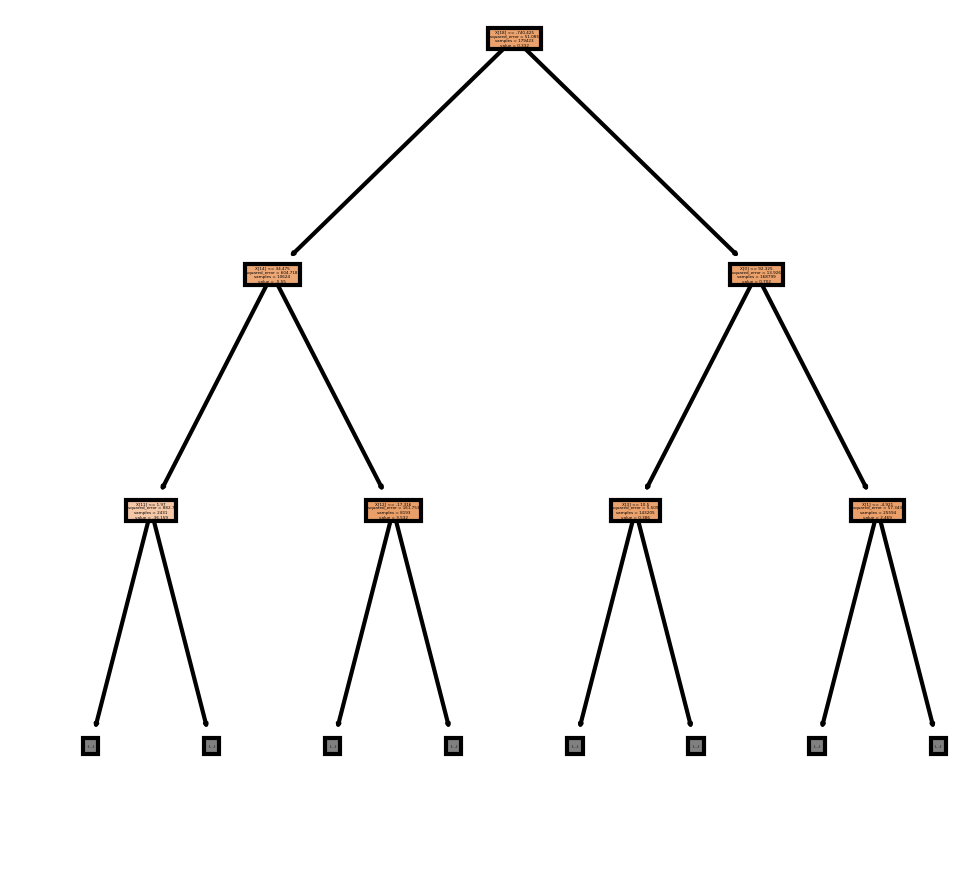

In [74]:

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (1,1), dpi=300)
tree.plot_tree(reg,max_depth=2,filled = True)
tree.export_graphviz(reg,
                     out_file="tree.dot",
                     max_depth=2,
                     feature_names = list(X_test.columns),
                     class_names=["Monthlt_return"],
                     filled = True)
fig.savefig('imagename.png')

In [ ]:
#strangles_test.loc[strangles_test["Strangle_id"]=="2021-03-25-15300.0-13800.0",['Date','Close_FUTleg1','Strike Priceleg1','Strike Priceleg2',"CallIV","PutIV",'Strangle_Price','Signal']]

In [ ]:
#x_cols

In [37]:
#strangles.loc[(strangles["Valid_Strangle"]=="YES")&(strangles['CE_ITMNESS']<-10.0)&(strangles['PE_ITMNESS']<-2.0)&(strangles['Days_To_Expiry']>2.0)&(strangles['Days_To_Expiry']>2.0),"Strangle_Return"].describe()
#strangles.loc[(strangles["Valid_Strangle"]=="YES")&(strangles['CE_ITMNESS']<-10.0)&(strangles['PE_ITMNESS']<-10.0)&(strangles['Days_To_Expiry']>2.0)&(strangles['Days_To_Expiry']>2.0),"Strangle_id"]
#strangles[strangles["Strangle_id"]=="2017-01-25-9100.0-7300.0"]
